In [70]:
import pandas as pd 
import numpy as np 
import os
import cv2 as cv

In [86]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout,BatchNormalization

In [72]:
train_ds = keras.utils.image_dataset_from_directory(
    directory='data',
    labels='inferred',
    validation_split=0.2,
    subset='training',
    seed=42,
    label_mode='binary',
    batch_size=32,
    image_size=(128,128)
)

Found 7553 files belonging to 2 classes.
Using 6043 files for training.


In [73]:
val_ds = keras.utils.image_dataset_from_directory(
    directory='data',
    labels='inferred',
    validation_split=0.2,
    subset='validation',
    seed=42,
    label_mode='binary',
    batch_size=32,
    image_size=(128,128)
)

Found 7553 files belonging to 2 classes.
Using 1510 files for validation.


In [90]:
Autotune = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=Autotune)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=Autotune)

In [74]:
data_augmentation = Sequential([
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomBrightness(0.1),
    keras.layers.RandomContrast(0.1)
])

In [75]:
model2 = Sequential([
    tf.keras.layers.Input(shape=(128,128,3)),
    data_augmentation,
    tf.keras.layers.Rescaling(1./255.)
])

model2.add(Conv2D(32,(3,3),activation='relu',padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2,2)))

model2.add(Conv2D(64,(3,3),activation='relu',padding='same'))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2,2)))

model2.add(Conv2D(64,(3,3),activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D((2,2)))

model2.add(Flatten())

model2.add(Dense(64,activation='relu',kernel_initializer='he_normal'))
model2.add(BatchNormalization())
model2.add(Dropout(0.4))
model2.add(Dense(1,activation='sigmoid'))

In [76]:
model2.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_12 (Sequential)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_9 (Rescaling)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 30, 30, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 30, 30, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │       921,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 978,945 (3.73 MB)

 Trainable params: 978,497 (3.73 MB)

 Non-trainable params: 448 (1.75 KB)

In [77]:
model2.compile(loss='binary_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=0.0005),metrics=['accuracy'])

In [78]:
earlyStopping = keras.callbacks.EarlyStopping(
    monitor = 'val_loss',
    patience = 3,
    restore_best_weights = True
)

In [79]:
history2 = model2.fit(train_ds,epochs=25,batch_size=32,validation_data=val_ds,callbacks=earlyStopping)

Epoch 1/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 34s 126ms/step - accuracy: 0.8519 - loss: 0.3693 - val_accuracy: 0.6404 - val_loss: 0.5499
Epoch 2/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.8762 - loss: 0.3042 - val_accuracy: 0.8596 - val_loss: 0.3330
Epoch 3/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 108ms/step - accuracy: 0.8885 - loss: 0.2848 - val_accuracy: 0.8967 - val_loss: 0.2570
Epoch 4/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 21s 109ms/step - accuracy: 0.8939 - loss: 0.2690 - val_accuracy: 0.9033 - val_loss: 0.2344
Epoch 5/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 104ms/step - accuracy: 0.8996 - loss: 0.2396 - val_accuracy: 0.9371 - val_loss: 0.1684
Epoch 6/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - accuracy: 0.9044 - loss: 0.2460 - val_accuracy: 0.9272 - val_loss: 0.1894
Epoch 7/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9093 - loss: 0.2237 - val_accuracy: 0.9291 - val_loss: 0.1679
Epoch 8/25
189/189 ━━━━━━━━━━━━━━━━━━━━ 19s 101ms/step - accuracy: 0.9110 - loss: 0

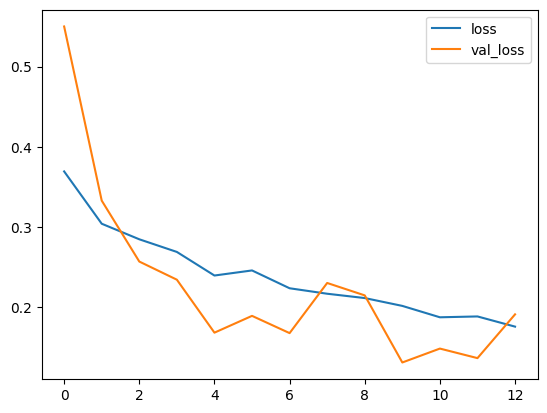

In [82]:
import matplotlib.pyplot as plt
plt.plot(history2.history['loss'],label='loss')
plt.plot(history2.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

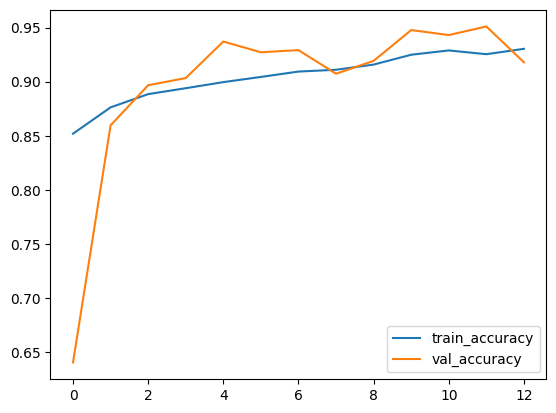

In [83]:
plt.plot(history2.history['accuracy'],label='train_accuracy')
plt.plot(history2.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [60]:
img = keras.utils.load_img('without mask.jpg',target_size=(128,128))

In [61]:
img_array = keras.utils.img_to_array(img)

In [62]:
img_array = tf.expand_dims(img_array,axis=0)

In [63]:
prediction = model2.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step


In [64]:
if prediction>0.5:
    print('without mask')
else:
    print('with mask')

without mask


In [81]:
train_loss,train_acc = model2.evaluate(train_ds)

189/189 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.9490 - loss: 0.1354


In [80]:
val_loss,val_acc = model2.evaluate(val_ds)

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9477 - loss: 0.1313


In [91]:
model2.save('face_mask_model.keras')